In [86]:
from scipy.io import netcdf
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import gsw
sns.set(context='talk',style='whitegrid',font_scale=1.3)
#from model_plotting import plot_snapshot,plot_snapshot_w
import scipy.linalg as la
# from spectra_module import spec2d

import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import hvplot.xarray

from deformtools.tools import alphabet

sns.set(style='ticks', context='paper', palette='colorblind',font_scale=1.3)
mpl.rc('figure', dpi=100, figsize=[11, 5])
mpl.rc('savefig', dpi=500, bbox='tight')
mpl.rc('legend', frameon=False)

In [3]:
zgrid = pd.read_csv('../data/psom/zgrid.out',skipinitialspace=True,sep=' ',header=None)
zgrid=zgrid[1].values

dirr='../data/psom/full_08325.cdf'
time = dirr.split('/')[-1].split('_')[1].split('.')[0]

f =  netcdf.netcdf_file(dirr, 'r')
u = f.variables['u'][:][33, 1:321, 1:193]
v= f.variables['v'][:][33, 1:321, 1:193]
vor= f.variables['vor'][:][33, 1:321, 1:193]/gsw.f(17)
xc = f.variables['xc'][1:193]
yc = f.variables['yc'][1:321]

In [4]:
#%%
import random
import math

def make_hex(x0,y0,L,skew):
    i=0
    xx=np.zeros(M)
    yy=np.zeros(M)
    
    degstart = random.randint(0,360)
    angle = np.arange(degstart,degstart+360,360//M)
    angle[angle>360] = angle[angle>360]-360 
    
    random_stretch = random.randint(0,2)
    for j,angle in enumerate( angle ):
        if j==random_stretch:
            alpha=skew
        else:
            alpha=1
        xx[i] = x0 + alpha*L*math.cos(math.radians(angle))
        yy[i] = y0 + alpha*L*math.sin(math.radians(angle))
        i+=1
        
    return xx,yy

def make_n_hexs(L,skew):
    x=np.zeros((N,M))
    y=np.zeros((N,M))
    for i in range(N):
        x0=(180-10)*random.random() + 10
        y0=(300-10)*random.random() + 10
        x[i,:],y[i,:] = make_hex(x0,y0,L,skew)
    return x,y

def least_square_method(x0,y0,u0,v0,switch):
    ncc = x0.size
     
    dlon=np.zeros(ncc)  
    dlat=np.zeros(ncc)  
    for i in range(ncc):
        dlon[i] =  (x0[i] - np.nanmean(x0))*1000
        # should be distance in m in x from COM
        dlat[i] =  (y0[i]-np.nanmean(y0))*1000
    f=gsw.f(17)
    
    R = np.mat( np.vstack( (np.ones((ncc,)) ,dlon, dlat) ).T )
    u0=np.mat(u0).T - np.nanmean(u0)
    v0=np.mat(v0).T - np.nanmean(v0)
    
    if switch==0:
        A,_,_,_=la.lstsq(R,u0)
        B,_,_,_=la.lstsq(R,v0)
    elif switch==1:
        A = np.linalg.inv(R.T*R)*R.T*u0
        B = np.linalg.inv(R.T*R)*R.T*v0
    else:
        A=np.linalg.solve(R,u0)
        B=np.linalg.solve(R,v0)
        
    vort = (B[1]-A[2])/f
    strain = np.sqrt( (A[1]-B[2])**2 + (B[1]+A[2])**2 ) /f
    div = ( A[1]+B[2] )/f

    return vort,strain,div


def area_method():
    return

def circulation_method():
    return

In [5]:
L=2
N = 10000
M=3
xi,yi = make_n_hexs(L,0)

#%%
from scipy import interpolate
meth='cubic'
xx,yy= np.meshgrid(xc,yc)

In [6]:
fu = interpolate.RectBivariateSpline(yc,xc,u)
fv = interpolate.RectBivariateSpline(yc,xc,v)
fzeta = interpolate.RectBivariateSpline(yc,xc,vor)

In [7]:
import bottleneck as bn
vortia=np.zeros(N)
vortib=np.zeros(N)

In [8]:
#%%
ui=np.zeros((N,M))
vi=np.zeros((N,M))
zetai=np.zeros((N,M))
zeta_at_mean = np.zeros(N)
for i in range(N):
    for j in range(xi[1,:].size):
        ui[i,j] = fu(yi[i,j],xi[i,j])
        vi[i,j] = fv(yi[i,j],xi[i,j])
        zetai[i,j] = fzeta(yi[i,j],xi[i,j])
    zeta_at_mean[i]=  fzeta( np.mean(yi[i]),np.mean(xi[i]) )

In [9]:
vort_drifters=np.zeros(N)
for i in range(N):
    vort_drifters[i],_,_=least_square_method(xi[i,:],yi[i,:],ui[i,:],vi[i,:],2)
    
df_comparison = pd.DataFrame({'model_zeta':zeta_at_mean,'drifter_zeta':vort_drifters},index=np.arange(N))

/usr/local/anaconda3/lib/python3.7/site-packages/seaborn/axisgrid.py:1847: UserWarning: JointGrid annotation is deprecated and will be removed in a future release.
  warnings.warn(UserWarning(msg))


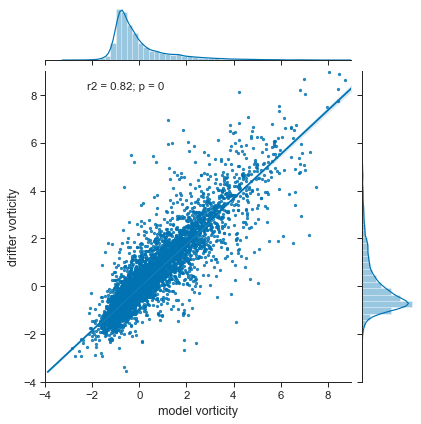

In [10]:
# model vs true
from scipy import stats
def r2(x, y):
    return stats.pearsonr(x, y)[0] ** 2,stats.pearsonr(x, y)[1]
g=sns.jointplot(x='model_zeta',y='drifter_zeta',data=df_comparison,
              kind='reg',stat_func=r2,scatter_kws={"s": 5})
plt.xlabel('model vorticity')
plt.ylabel('drifter vorticity')

g.ax_joint.set_xticks([-4,-2,0,2,4,6,8])
g.ax_joint.set_xlim([-4,9])
g.ax_joint.set_ylim([-4,9])
#g.ax_joint.set_yticks([-2,-1,0,1,2,3,4,5])
plt.savefig('performance.pdf',bb_inches='tight',dpi=600)
plt.show()

In [11]:
from scipy.ndimage import gaussian_filter

In [12]:
mode ='constant'
vor_5km = gaussian_filter(vor,sigma=5,mode=mode)
u_5km = gaussian_filter(u,sigma=5,mode=mode)
v_5km = gaussian_filter(v,sigma=5,mode=mode)
vor_10km = gaussian_filter(vor,sigma=10,mode=mode)
u_10km = gaussian_filter(u,sigma=10,mode=mode)
v_10km = gaussian_filter(v,sigma=10,mode=mode)

In [13]:
fu = interpolate.RectBivariateSpline(yc,xc,u)
fv = interpolate.RectBivariateSpline(yc,xc,v)
fzeta = interpolate.RectBivariateSpline(yc,xc,vor)
# 10km
fu5 = interpolate.RectBivariateSpline(yc,xc,u_5km)
fv5 = interpolate.RectBivariateSpline(yc,xc,v_5km)
fzeta5 = interpolate.RectBivariateSpline(yc,xc,vor_5km)
# 20km
fu10 = interpolate.RectBivariateSpline(yc,xc,u_10km)
fv10 = interpolate.RectBivariateSpline(yc,xc,v_10km)
fzeta10 = interpolate.RectBivariateSpline(yc,xc,vor_10km)

In [14]:
#%%
ui=np.zeros((N,M))
vi=np.zeros((N,M))
ui5=np.zeros((N,M))
vi5=np.zeros((N,M))
ui10=np.zeros((N,M))
vi10=np.zeros((N,M))
zeta_at_mean = np.zeros(N)
zeta_at_mean5 = np.zeros(N)
zeta_at_mean10 = np.zeros(N)
for i in range(N):
    for j in range(xi[1,:].size):
        ui[i,j] = fu(yi[i,j],xi[i,j])
        vi[i,j] = fv(yi[i,j],xi[i,j])
        ui5[i,j] = fu5(yi[i,j],xi[i,j])
        vi5[i,j] = fv5(yi[i,j],xi[i,j])
        ui10[i,j] = fu10(yi[i,j],xi[i,j])
        vi10[i,j] = fv10(yi[i,j],xi[i,j])
    zeta_at_mean[i]=  fzeta( np.mean(yi[i]),np.mean(xi[i]) )
    zeta_at_mean5[i]=  fzeta5( np.mean(yi[i]),np.mean(xi[i]) )
    zeta_at_mean10[i]=  fzeta10( np.mean(yi[i]),np.mean(xi[i]) )

In [16]:
vort_drifters=np.zeros(N)
vort_drifters5=np.zeros(N)
vort_drifters10=np.zeros(N)
for i in range(N):
    vort_drifters[i],_,_=least_square_method(xi[i,:],yi[i,:],ui[i,:],vi[i,:],2)
    vort_drifters5[i],_,_=least_square_method(xi[i,:],yi[i,:],ui5[i,:],vi5[i,:],2)
    vort_drifters10[i],_,_=least_square_method(xi[i,:],yi[i,:],ui10[i,:],vi10[i,:],2)

In [17]:
df_comparison = pd.DataFrame({'model_zeta':zeta_at_mean,'drifter_zeta':vort_drifters,
                             'model_zeta10':zeta_at_mean5,'drifter_zeta10':vort_drifters5,
                             'model_zeta20':zeta_at_mean10,'drifter_zeta20':vort_drifters10},index=np.arange(N) )

In [121]:
from scipy.stats import pearsonr

In [122]:
pearsonr(df_comparison.model_zeta, df_comparison.drifter_zeta)

(0.9069609671774272, 0.0)

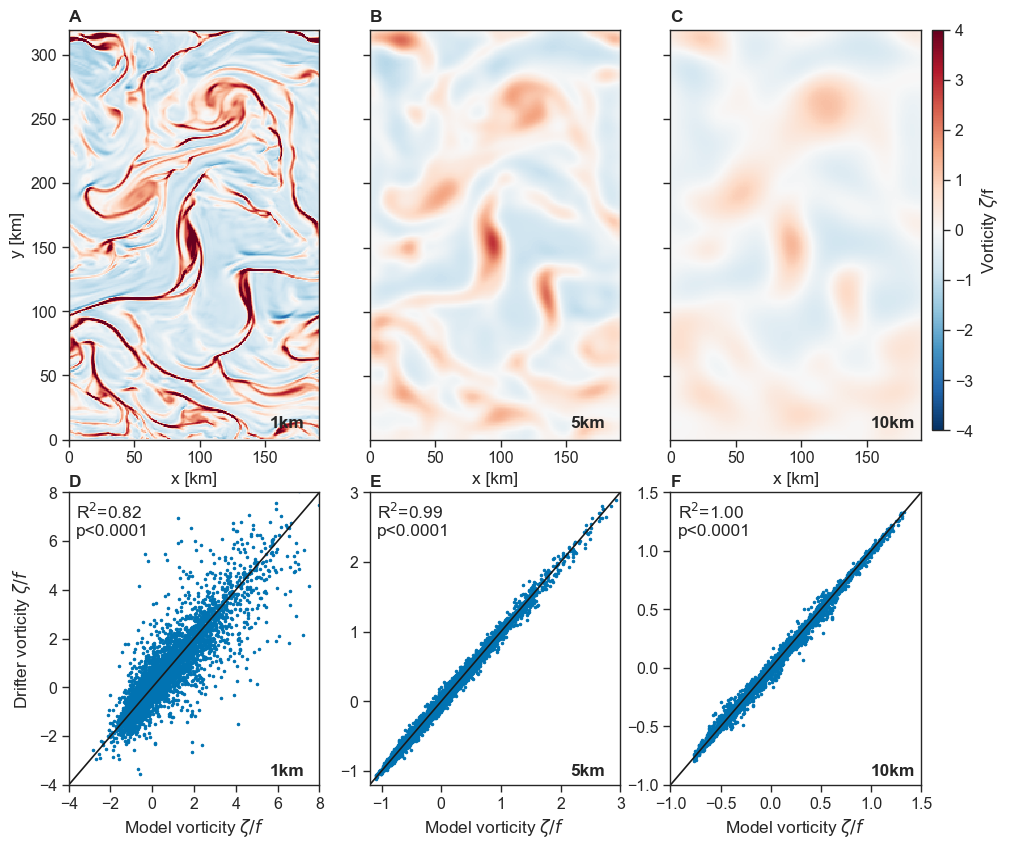

In [148]:
f = plt.figure(figsize=(11,10))
widths = [1,1,1]
heights = [1.4,1]
spec = f.add_gridspec(ncols=3,
                      nrows=2,
                      width_ratios=widths,
                      height_ratios=heights)

ax1 = f.add_subplot(spec[0, 0])
ax2 = f.add_subplot(spec[0, 1], sharey=ax1)
ax3 = f.add_subplot(spec[0, 2], sharey=ax1)
plt.setp(ax2.get_yticklabels(), visible=False)
plt.setp(ax3.get_yticklabels(), visible=False)

h3 = ax1.pcolormesh(xc, yc, vor, cmap='RdBu_r',rasterized=True, vmin=-4,vmax=4)
ax2.pcolormesh(xc, yc, vor_5km, cmap='RdBu_r',rasterized=True, vmin=-4,vmax=4)
ax3.pcolormesh(xc, yc, vor_10km, cmap='RdBu_r',rasterized=True, vmin=-4,vmax=4)
ax1.set_yticks(np.arange(0,305,50))
ax1.set_xticks(np.arange(0,155,50))
ax2.set_xticks(np.arange(0,155,50))
ax3.set_xticks(np.arange(0,155,50))
ax1.set_ylabel('y [km]')
ax1.set_xlabel('x [km]')
ax2.set_xlabel('x [km]')
ax3.set_xlabel('x [km]')


a = ax3.get_position() # pos left, bottom, width, height
cbar_ax = f.add_axes([a.bounds[0]+a.bounds[2]+0.01, a.bounds[1], 0.01, a.bounds[3] ]) #
cbar = f.colorbar(h3, cax=cbar_ax,ticks=np.arange(-4,5),label='Vorticity $\zeta$/f')
cbar.ax.set_xticklabels(np.arange(-4,5))

ax4 = f.add_subplot(spec[1, 0])

ax4.scatter(x='model_zeta',y='drifter_zeta',data=df_comparison, s=3)
ax4.set_xlabel('Model vorticity $\zeta/f$')
ax4.set_ylabel('Drifter vorticity $\zeta/f$')
ax4.set_xlim(-4,8)
ax4.set_ylim(-4,8)
ax4.set_xticks(np.arange(-4,10,2))
ax4.plot([-4,8],[-4,8], color='k')

ax5 = f.add_subplot(spec[1, 1])
ax5.scatter(x='model_zeta10',y='drifter_zeta10',data=df_comparison, s=3)
ax5.set_xlabel('Model vorticity $\zeta/f$')
# ax5.set_ylabel('Drifter vorticity $\zeta/f$')
ax5.set_xlim(-1.2,3)
ax5.set_ylim(-1.2,3)
ax5.set_yticks(np.arange(-1,4,1))
ax5.plot([-1.2,3],[-1.2,3], color='k')


ax6 = f.add_subplot(spec[1, 2])
ax6.scatter(x='model_zeta20',y='drifter_zeta20',data=df_comparison, s=3)

ax6.set_xlabel('Model vorticity $\zeta/f$')
# ax6.set_ylabel('Drifter vorticity $\zeta/f$')
ax6.set_xlim(-1,1.5)
ax6.set_ylim(-1,1.5)
ax6.plot([-1,1.5],[-1,1.5], color='k')
# ax6.set_yticklabels([])

ax1.annotate('1km',(0.8,0.03),xycoords='axes fraction',weight='bold')
ax2.annotate('5km',(0.8,0.03),xycoords='axes fraction',weight='bold')
ax3.annotate('10km',(0.8,0.03),xycoords='axes fraction',weight='bold')
ax4.annotate('1km',(0.8,0.03),xycoords='axes fraction',weight='bold')
ax5.annotate('5km',(0.8,0.03),xycoords='axes fraction',weight='bold')
ax6.annotate('10km',(0.8,0.03),xycoords='axes fraction',weight='bold')

r,p = pearsonr(df_comparison.model_zeta, df_comparison.drifter_zeta)
r2=r**2
ax4.annotate(rf'R$^2$={r2:2.2f}'+'\n'+r'p<0.0001',(0.03,0.85),xycoords='axes fraction')

r,p = pearsonr(df_comparison.model_zeta10, df_comparison.drifter_zeta10)
r2=r**2
ax5.annotate(rf'R$^2$={r2:2.2f}'+'\n'+r'p<0.0001',(0.03,0.85),xycoords='axes fraction')
r,p = pearsonr(df_comparison.model_zeta20, df_comparison.drifter_zeta20)
r2=r**2
# ax6.annotate(rf'R$^2$={r:2.2f}',(0.03,0.9),xycoords='axes fraction')
ax6.annotate(rf'R$^2$={r2:2.2f}'+'\n'+r'p<0.0001',(0.03,0.85),xycoords='axes fraction')

# spec.tight_layout(f)
spec.update(hspace=0.15,wspace=0.2)

alphabet([ax1,ax2,ax3,ax4,ax5,ax6])

plt.savefig('../figures/performance_v2.pdf',bb_inches='tight',dpi=600)